`py_grama`

---

A demonstration

In [1]:
# Setup
import grama as gr
from grama.models import make_cantilever_beam
md_beam = make_cantilever_beam()

In [2]:
# Models have both *functions* and *distributions*
md_beam.printpretty()

model: Cantilever Beam

  inputs:
    var_det:
      w: [2, 4]
      t: [2, 4]
    var_rand:
      H: (+1) norm, {'loc': 500.0, 'scale': 100.0}
      V: (+1) norm, {'loc': 1000.0, 'scale': 100.0}
      E: (+0) norm, {'loc': 29000000.0, 'scale': 1450000.0}
      Y: (-1) norm, {'loc': 40000.0, 'scale': 2000.0}
    copula:
        Independence copula
  functions:
    cross-sectional area: ['w', 't'] -> ['c_area']
    limit state: stress: ['w', 't', 'H', 'V', 'E', 'Y'] -> ['g_stress']
    limit state: displacement: ['w', 't', 'H', 'V', 'E', 'Y'] -> ['g_disp']


# Model Analysis


In [3]:
# The model has a function + distribution;
# Monte Carlo is now a one-liner
df_mc = md_beam >> gr.ev_monte_carlo(n=100, df_det="nom")

df_mc.describe()

,V,H,E,Y,w,t,c_area,g_stress,g_disp
count,100.000000,100.000000,1.000000e+02,100.000000,100.0,100.0,100.0,100.000000,100.000000
mean,996.118483,499.901899,2.896250e+07,39703.081906,3.0,3.0,9.0,6458.184524,0.339494
std,103.227135,101.529422,1.543579e+06,2098.781182,0.0,0.0,0.0,3874.249052,0.199296
min,705.185592,233.946394,2.640716e+07,34734.830204,3.0,3.0,9.0,-4327.299195,-0.316738
25%,936.157616,438.257421,2.789833e+07,38229.104608,3.0,3.0,9.0,4395.801678,0.239496
50%,1001.147652,498.109281,2.873054e+07,39558.242270,3.0,3.0,9.0,6289.021234,0.330038
75%,1056.147362,563.890551,2.995469e+07,41309.217292,3.0,3.0,9.0,8441.644085,0.451591
max,1320.450704,770.658814,3.393368e+07,46224.529273,3.0,3.0,9.0,19026.801144,0.879362


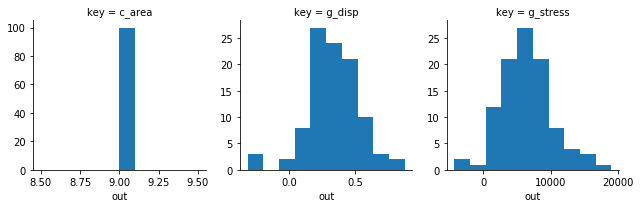

In [4]:
# The resulting data have model context for plotting
df_mc >> gr.pt_auto()

In [5]:
# Utilities for sensitivity analysis
md_beam >> \
    gr.ev_hybrid(n=500, df_det="nom") >> \
    gr.tf_sobol()

,c_area,g_disp,g_stress,ind
0,0.0,0.29,0.03,S_E
0,0.0,0.17,0.30,S_H
0,0.0,0.61,0.41,S_V
0,0.0,0.05,0.29,S_Y


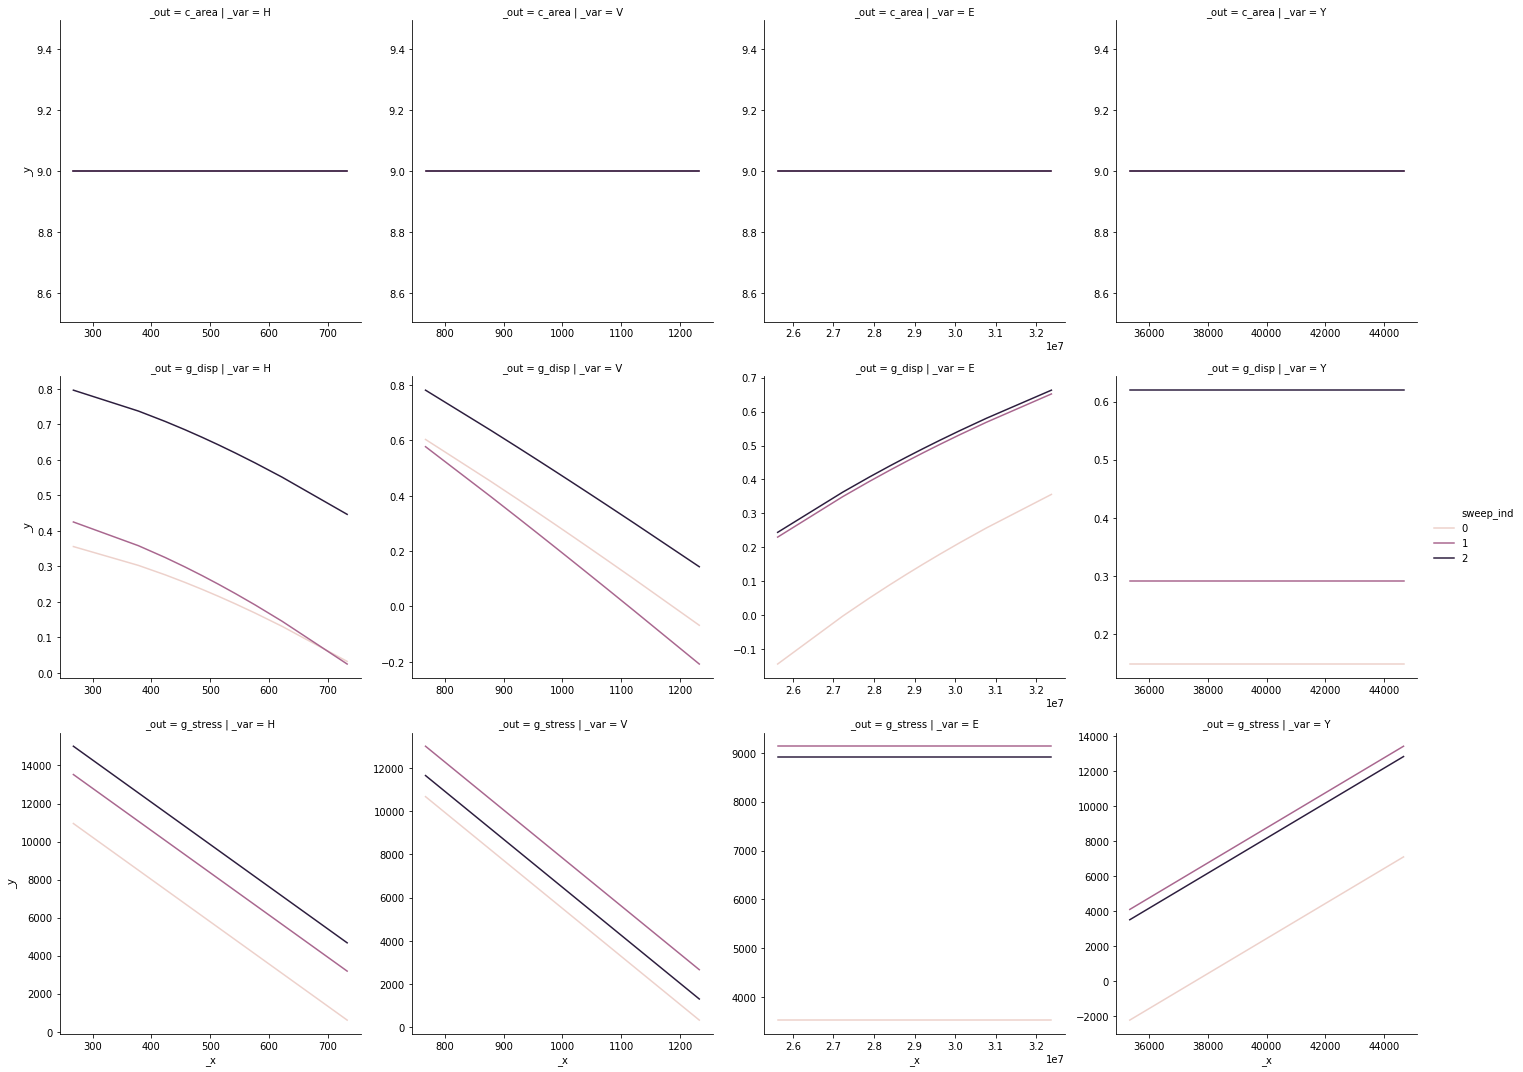

In [6]:
# Graphical exploration
md_beam >> \
    gr.ev_sinews(df_det="nom", skip=False) >> \
    gr.pt_auto()
# rm `skip` for evaluation

# Model Building

In [7]:
# Models are built in stages
md_test = gr.Model("My model") >> \
    gr.cp_function(
        fun=lambda x: x[0] + x[1],
        var=2,
        out=1
    ) >> \
    gr.cp_bounds(
        x0=(0, 1)
    ) >> \
    gr.cp_marginals(
        x1={"dist": "uniform", "loc": 0, "scale": 1}
    )
md_test.printpretty()

model: My model

  inputs:
    var_det:
      x0: [0, 1]
    var_rand:
      x1: (+0) uniform, {'loc': 0, 'scale': 1}
    copula:
        None
  functions:
    <lambda>: ['x0', 'x1'] -> ['y0']


In [8]:
# Models are not valid without an explicit dependence structure!
# md_test >> gr.ev_monte_carlo(df_det="nom")

In [9]:
# We can update a model; this allows us to
# build up in stages
md_test = \
    md_test >> \
    gr.cp_copula_independence()
md_test.printpretty()
md_test >> gr.ev_monte_carlo(df_det="nom", seed=101)

model: My model

  inputs:
    var_det:
      x0: [0, 1]
    var_rand:
      x1: (+0) uniform, {'loc': 0, 'scale': 1}
    copula:
        Independence copula
  functions:
    <lambda>: ['x0', 'x1'] -> ['y0']


,x1,x0,y0
0,0.516399,0.5,1.016399


In [10]:
# We can fit distributions from data...
from grama.data import df_stang
md_stang = gr.Model("E, mu distribution") >> \
    gr.cp_marginals(
        E=gr.continuous_fit(df_stang.E, "norm"),
        mu=gr.continuous_fit(df_stang.mu, "beta")
    ) >> \
    gr.cp_copula_gaussian(df_data=df_stang)
md_stang.printpretty()

model: E, mu distribution

  inputs:
    var_det:
    var_rand:
      E: (+0) norm, {'loc': 10344.736842105263, 'scale': 258.7392188662194}
      mu: (+0) beta, {'a': 1.0039017654316746, 'b': 0.8622680473775106, 'loc': 0.3094053248270583, 'scale': 0.021594675172941728}
    copula:
        Gaussian copula with correlations:
  var1 var2      corr
0   mu    E  0.371244
  functions:


eval_monte_carlo() is rounding n...
Design runtime estimates unavailable; model has no timing data.


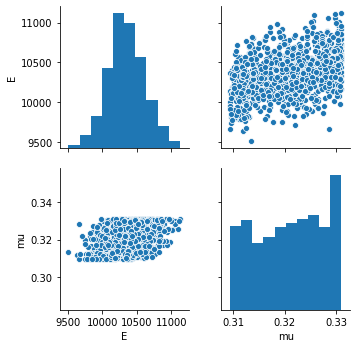

In [11]:
# and we can simulate from those fits
df_stang_synthetic = \
    md_stang >> \
    gr.ev_monte_carlo(n=1e3, df_det="nom", skip=True)
df_stang_synthetic >> gr.pt_auto()

In [13]:
# Some UQ knowledge is built into the tools
# md_stang >> gr.ev_hybrid(n=500, df_det="nom")

# Surrogate / Metamodels

In [14]:
# Can build metamodels on data;
# fit a gaussian process
from grama.fit import fit_gp

md_beam_meta = \
    fit_gp(
        df_mc,
        md=md_beam
    )
# Metamodel inherits model distribution
md_beam_meta.printpretty()

fit_gp is assigning default kernel


       -3.70514574e-05, -7.94032589e-04, -0.00000000e+00]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 91, 'nit': 32, 'warnflag': 2}


model: None

  inputs:
    var_det:
      w: [2, 4]
      t: [2, 4]
    var_rand:
      H: (+1) norm, {'loc': 500.0, 'scale': 100.0}
      V: (+1) norm, {'loc': 1000.0, 'scale': 100.0}
      E: (+0) norm, {'loc': 29000000.0, 'scale': 1450000.0}
      Y: (-1) norm, {'loc': 40000.0, 'scale': 2000.0}
    copula:
        Independence copula
  functions:
    GP (0.0316**2 * RBF(length_scale=[1e+08, 1, 1e+08, 1e+08, 1e+08, 1])): ['H', 'w', 'V', 'Y', 'E', 't'] -> ['c_area']
    GP (3.29**2 * RBF(length_scale=[3.1, 1, 2.95, 7.65e+07, 3.42, 1])): ['H', 'w', 'V', 'Y', 'E', 't'] -> ['g_disp']
    GP (31.6**2 * RBF(length_scale=[140, 1, 123, 146, 7e+07, 1])): ['H', 'w', 'V', 'Y', 'E', 't'] -> ['g_stress']


       -0.00768569, -0.        ]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 67, 'nit': 21, 'warnflag': 2}


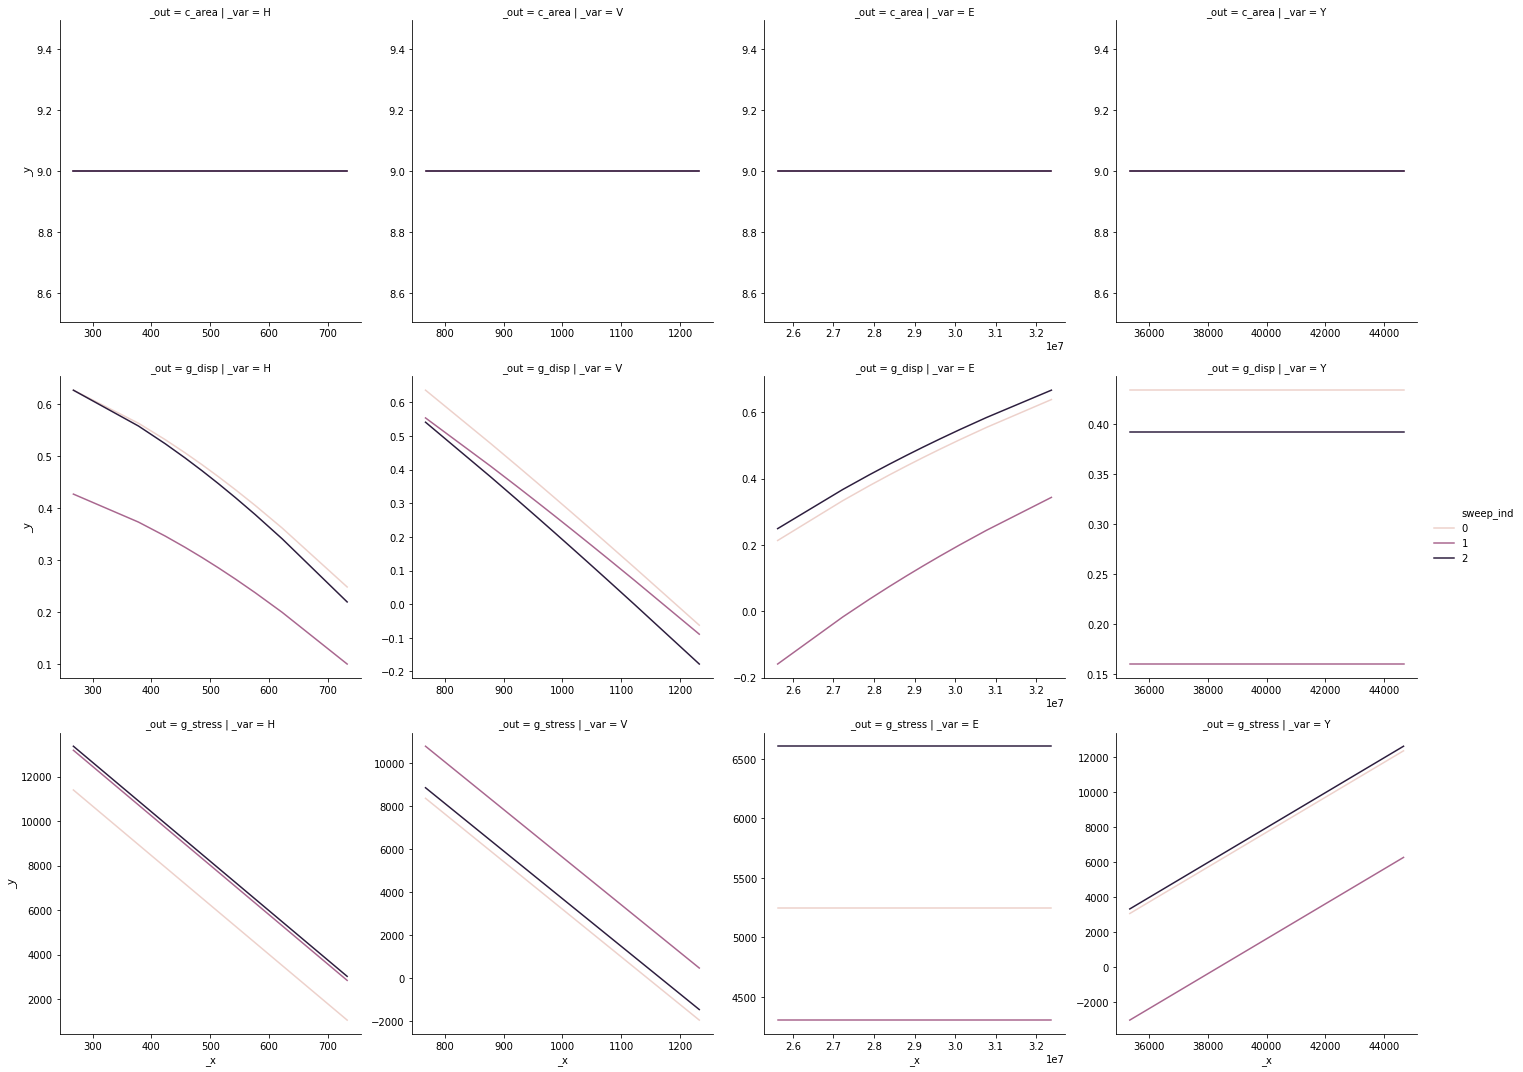

In [15]:
# Perform qualitative checks on a learned model
md_beam_meta >> \
    gr.ev_sinews(df_det="nom") >> \
    gr.pt_auto()

In [ ]:
# fit_gp is a wrapper; we can use a scikit-learn kernel
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as Con
kernel = Con(1, (1e-3, 1e+3)) * RBF([1] * 6, (1e-8, 1e+8))

# Layered options with sensible defaults
md_beam_custom = \
    fit_gp(
        df_mc,
        md=md_beam,
        kernel=kernel
    )
md_beam_custom.printpretty()
